In [170]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
sys.path.insert(1,'E:\\User\\Stevens\\Spring 2024\\PTO - Fairness\\myGit\\myUtils')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [171]:
alpha = 10

In [172]:
# Utility functions
def genData(num_data, num_features, num_items, seed=42, Q=100, dim=1, deg=1, noise_width=0.5, epsilon=0.1):
    rnd = np.random.RandomState(seed)
    n = num_data
    p = num_features
    m = num_items
    
    # Split the population into group A (1/4) and group B (3/4)
    group_A_size = n // 4
    group_B_size = n - group_A_size
    
    # Generate x with a bias for group A
    x = np.zeros((n, m, p))
    x[:group_A_size] = rnd.normal(0.5, 1, (group_A_size, m, p))  # Slightly higher mean for group A
    x[group_A_size:] = rnd.normal(0, 1, (group_B_size, m, p))   # Standard distribution for group B
    
    B = rnd.binomial(1, 0.5, (m, p))

    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            values = (np.dot(B[j], x[i, j].reshape(p, 1)).T / np.sqrt(p) + 3) ** deg + 1
            values *= 5
            values /= 3.5 ** deg
            epislon = rnd.uniform(1 - noise_width, 1 + noise_width, 1)
            values *= epislon
            
            # Introduce bias for c: Group A has slightly higher values, Group B slightly lower
            if i < group_A_size:
                values *= 1.1  # Increase c for Group A
            else:
                values *= 0.9  # Decrease c for Group B
            
            values = np.ceil(values)
            c[i, j] = values

    c = c.astype(np.float64)
    
    w = rnd.normal(0, 1, (m, p))
    
    # Generate b with a slight bias for group A
    b = np.zeros((n, m))
    b[:group_A_size] = rnd.normal(0.5, 1, (group_A_size, m))  # Slightly higher bias for group A
    b[group_A_size:] = rnd.normal(0, 1, (group_B_size, m))    # Standard distribution for group B
    
    r = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            r[i, j] = np.dot(w[j], x[i, j])**2 + b[i, j]
            
            # Introduce bias for r: Group A has slightly lower values, Group B slightly higher
            if i < group_A_size:
                r[i, j] -= 0.2  # Decrease r for Group A
            else:
                r[i, j] += 0.2  # Increase r for Group B

    r = 1 / (1 + np.exp(-r))  # Sigmoid function to r

    return x, r, c, Q


class optModel:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items
        
    def __repr__(self):
        return 'optModel ' + self.__class__.__name__

    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)

    @staticmethod
    def helperSolve(r, c, Q, alpha):

        d = cp.Variable(num_items)
        if alpha == 1:
            raise ValueError("Work in progress")
        else:
            objective = cp.sum(cp.power(cp.multiply(r, d), 1 - alpha)) / (1 - alpha)



    def solve(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value

        return opt_sol, opt_val

    def solveC(self):
        """
        A method to solve the optimization problem in closed form for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization

        Returns:
            tuple: optimal solution and optimal value
        """
        r = self.r
        c = self.c
        if self.alpha == 1:
            raise ValueError("Work in progress")
        c = c.cpu().numpy() if isinstance(c, torch.Tensor) else c
        r = r.cpu().numpy() if isinstance(r, torch.Tensor) else r
        S = np.sum(c ** (1 - 1 / self.alpha) * r ** (-1 + 1 / self.alpha))
        opt_sol_c = (c ** (-1 / self.alpha) * r ** (-1 + 1 / self.alpha) * self.Q) / S
        opt_val_c = np.sum((r * opt_sol_c) ** (1 - self.alpha)) / (1 - self.alpha)

        return opt_sol_c, opt_val_c


   
class optDataset(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, r, Q, alpha, closed=False):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): optimization model
            features (np.ndarray): features
            c (np.ndarray): c of objective function
            r (np.ndarray): r of objective function
            Q (float): budget
            alpha (float): alpha of objective function
            closed (bool): solving the problem in closed form

        """
        self.feats = features
        self.costs = costs
        self.r = r
        self.Q = Q
        self.alpha = alpha
        self.closed = closed

        self.sols, self.objs = self._getSols()

    def _getSols(self):
        """
        A method to get the solutions of the optimization problem
        """
        opt_sols = []
        opt_objs = []
        
        for i in tqdm(range(len(self.costs))):
            sol, obj = self._solve(self.r[i], self.costs[i])
            opt_sols.append(sol)
            opt_objs.append([obj])
        
        return np.array(opt_sols), np.array(opt_objs)
    
    def  _solve(self, r, c):
        """
        A method to solve the optimization problem to get oan optimal solution with given r and c

        Args:
            r (np.ndarray): r of objective function
            c (np.ndarray): c of objective function

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        self.model = optModel(r, c, self.Q, self.alpha)

        return self.model.solve(closed=self.closed)
    

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)
    
    def __getitem__(self, index):
        """
        A method to retrieve data

        Args:
            index (int): data index

        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), optimal solutions (torch.tensor) and objective values (torch.tensor)
        """
        return (
            torch.FloatTensor(self.feats[index]), # x 
            torch.FloatTensor(self.costs[index]), # c
            torch.FloatTensor(self.r[index]), # r 
            torch.FloatTensor(self.sols[index]),# optimal solution
            torch.FloatTensor(self.objs[index]), # objective value
        )
    
    

def regret(predmodel, optmodel, dataloader, alpha=alpha):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, r, d, z  = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()
        # predict
        with torch.no_grad(): # no grad
            rp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(rp.shape[0]):
            # accumulate loss
            loss += calRegret(optModel, c[j].to("cpu").detach().numpy(), rp[j], r[j].to("cpu").detach().numpy(),
                              z[j].item(),alpha=alpha)
        optsum += abs(z).sum().item()
    # turn back train mode
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)

def objValue(d, r, alpha):
    """
    A function to calculate objective value
    """
    if alpha == 1:
        return np.sum(np.log(np.multiply(r, d)))
    else:
        return np.sum(np.power(np.multiply(r, d), 1 - alpha)) / (1 - alpha)


def calRegret(optmodel, cost, pred_r, true_r, true_obj, alpha=alpha):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(pred_r, cost, Q, alpha)
    sol, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_r, alpha)
    # loss
    loss = true_obj - obj
    return loss

# Define the visualization function
def visLearningCurve(loss_log, loss_log_regret):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.03)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

In [173]:
class LinearRegressionModel(nn.Module):
    def __init__(self, num_items, num_features):
        super(LinearRegressionModel, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.linears = nn.ModuleList([nn.Linear(num_features, 1) for _ in range(num_items)])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.linears[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)

In [174]:
num_data = 20000
num_features = 20
num_items = 5
alpha = 0.5
x, r, c, Q = genData(num_data, num_features, num_items)
# create optmodel instance
optmodel = optModel(r, c, Q, alpha=alpha)

In [175]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, r_train, r_test = train_test_split(x, c, r, test_size=0.2, random_state=42)



In [176]:
# Create datasets and dataloaders
dataset_train = optDataset(x_train, c_train, r_train, Q, alpha=alpha, closed=True)
dataset_test = optDataset(x_test, c_test, r_test, Q, alpha=alpha, closed=True)
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

100%|██████████| 4000/4000 [00:00<00:00, 98578.17it/s]


In [177]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2, *,alpha):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test, alpha=alpha)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)
            
            # loss = loss_func(rp, r) if using torch.nn.MSELoss
            loss = loss_func(rp, r)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        regret_loss = regret(predmodel, optmodel, loader_test, alpha=alpha)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))
    predmodel.eval()
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

In [178]:
# Define the visualization function
def visLearningCurve(loss_log, loss_log_regret):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.03)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

Epoch  1,  Loss:    0.1143,  Regret:  0.7756%
Epoch  2,  Loss:    0.0788,  Regret:  0.6435%
Epoch  3,  Loss:    0.0466,  Regret:  0.6050%
Epoch  4,  Loss:    0.0481,  Regret:  0.5916%
Epoch  5,  Loss:    0.0387,  Regret:  0.5851%
Epoch  6,  Loss:    0.0369,  Regret:  0.5812%
Epoch  7,  Loss:    0.0356,  Regret:  0.5791%
Epoch  8,  Loss:    0.0262,  Regret:  0.5774%
Epoch  9,  Loss:    0.0353,  Regret:  0.5767%
Epoch 10,  Loss:    0.0281,  Regret:  0.5759%
Total Elapsed Time: 3513.09 Sec.


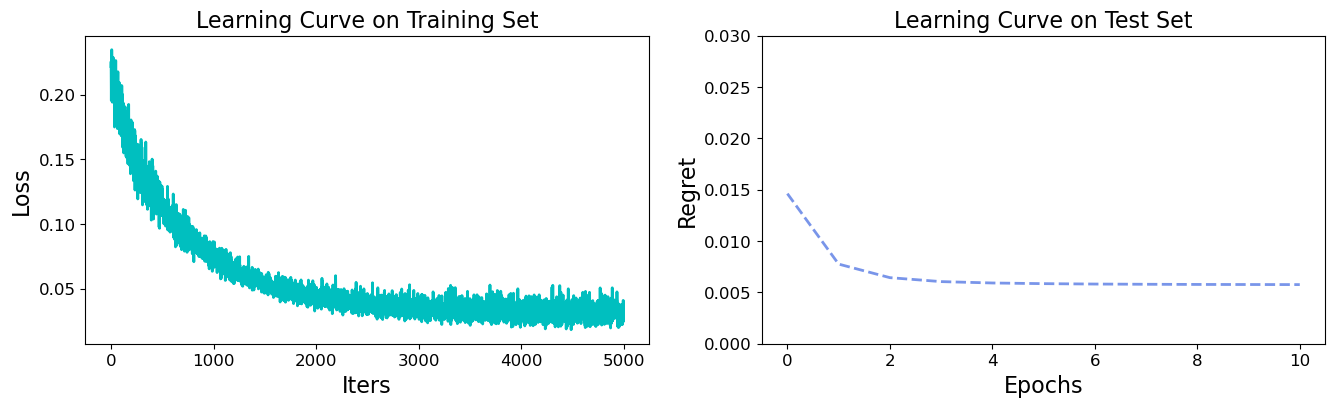

In [179]:
optmodel = optModel
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = nn.MSELoss()

# Run the training
loss_log, loss_log_regret = trainModel(model, criterion, num_epochs=10, lr=1e-3, alpha=alpha)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret)